# Experiment - Gender Prediction
* StellarAlgo Data Science
* March 24, 2023
* Grant Donst, Peter Morrison

In [1]:
import pandas as pd
import os

from data_sci_toolkit.aws_tools import redshift_tools
from pycaret.classification import *

import gender_guesser.detector as gender

# Load in Data

Running query to gather first name, gender, and other possible features from cohortcustomer, cohortmerch, and cohortconcession

In [2]:
query = """
select cc.gender, cc.dimcustomermasterid, cc.lkupclientid, cc.namefirst, cc.income, cc.education, cc.occupation, cc.monetary_tier_overall, cc.engagementbucket, cc.loyaltypointbalance, cc.isgamer, cm.itemdescription, cm.itemcount, cm.itemrevenue, ccon.purchasecount, ccon.totalspent
from dw.cohortcustomer cc 
	left join dw.cohortmerch cm on cc.dimcustomermasterid = cm.dimcustomermasterid 
	left join dw.cohortconcession ccon on cc.dimcustomermasterid = ccon.dimcustomermasterid 
where cc.gender is not null 
and cc.namefirst is not null;
"""

cluster = "prod-app"
database = "stlrtrailblazers"

In [3]:
conn = redshift_tools.get_redshift_connection(cluster, database)

cur = conn.cursor()
cur.execute(query)

data = cur.fetchall()

cols = [row[0] for row in cur.description]
df = pd.DataFrame(data=data, columns=cols)

conn.close()

Authorized as AROASQ4JELIXYLYV6P4UV:pmorrison@stellaralgo.com


In [4]:
df_temp = df

In [5]:
df_temp.shape

(1657756, 16)

# Pre-Processing

We will preprocess the data, so we can have a predicted score of their gender and clean other data.

In [6]:
gdectect = gender.Detector()

In [7]:
df_temp["name_gender_predict"] = df_temp["namefirst"].apply(gdectect.get_gender)

In [8]:
df_temp.name_gender_predict.value_counts()

male             637978
female           631745
unknown          221929
mostly_female     85508
mostly_male       66892
andy              13704
Name: name_gender_predict, dtype: int64

In [9]:
df_temp["totalspent"] = df_temp["totalspent"].fillna(0)

In [10]:
df_temp["itemcount"] = df_temp["itemcount"].fillna(0)

In [11]:
df_temp["gender"] = df_temp["gender"].apply(lambda x: x.lower())

In [12]:
df_temp["gender"].value_counts()

female    836257
male      821380
o            119
Name: gender, dtype: int64

# Train Model

In [13]:
setup(
    data=df_temp,
    target='gender',
    train_size=0.85,
    data_split_shuffle=True,
    silent=True,
    verbose=False,
    ignore_features=["dimcustomermasterid", "lkupclientid", "namefirst", "itemdescription"],
    numeric_features=["totalspent"]
)

(8559,
 'lightgbm',
 False,
          totalspent  income_112500  income_124999  income_17500  income_25000  \
 0               0.0            0.0            0.0           0.0           0.0   
 1               0.0            0.0            1.0           0.0           0.0   
 2               0.0            0.0            0.0           0.0           0.0   
 3               0.0            1.0            0.0           0.0           0.0   
 4               0.0            0.0            0.0           1.0           0.0   
 ...             ...            ...            ...           ...           ...   
 1657751         0.0            1.0            0.0           0.0           0.0   
 1657752         0.0            0.0            1.0           0.0           0.0   
 1657753         0.0            0.0            0.0           0.0           0.0   
 1657754         0.0            0.0            1.0           0.0           0.0   
 1657755         0.0            0.0            0.0           0.0      

In [14]:
model_matrix = compare_models(
    fold=2,
    include= ["lightgbm", "catboost", "rf", "svm", "xgboost", "mlp"]
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.9049,0.9654,0.6032,0.9051,0.9049,0.8098,0.8101,13.4500
xgboost,Extreme Gradient Boosting,0.9049,0.9653,0.6033,0.9051,0.9049,0.8098,0.8101,148.2800
catboost,CatBoost Classifier,0.9048,0.9652,0.6032,0.9050,0.9048,0.8096,0.8098,29.1600
mlp,MLP Classifier,0.9046,0.9651,0.6030,0.9046,0.9045,0.8091,0.8092,28.4500
rf,Random Forest Classifier,0.9029,0.9625,0.6019,0.9030,0.9029,0.8058,0.8060,15.5600
svm,SVM - Linear Kernel,0.8984,0.0000,0.5986,0.9044,0.8979,0.7965,0.8027,2.3900


In [15]:
best_model = create_model(model_matrix, fold=2);

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9052,0.9654,0.6034,0.9054,0.9051,0.8103,0.8106
1,0.9047,0.9653,0.6031,0.9048,0.9046,0.8093,0.8096
Mean,0.9049,0.9654,0.6032,0.9051,0.9049,0.8098,0.8101
Std,0.0002,0.0000,0.0002,0.0003,0.0002,0.0005,0.0005


In [16]:
best_model = tune_model(best_model)

IntProgress(value=0, description='Processing: ', max=7)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,15:30:19
Status,. . . . . . . . . . . . . . . . . .,Searching Hyperparameters
Estimator,. . . . . . . . . . . . . . . . . .,Light Gradient Boosting Machine


,Fold,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC


Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will b

[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:  2.9min


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will b

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 102.9min finished


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will b

In [ ]:
final_model = finalize_model(best_model)

[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will b

/Users/petermorrison/miniforge3/envs/stellar/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/petermorrison/miniforge3/envs/stellar/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/petermorrison/miniforge3/envs/stellar/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Use

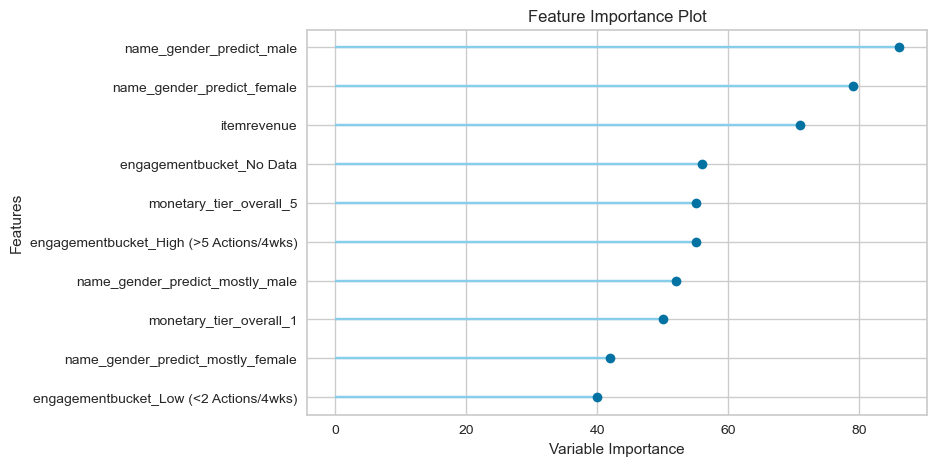

In [ ]:
plot_model(best_model, plot="feature")

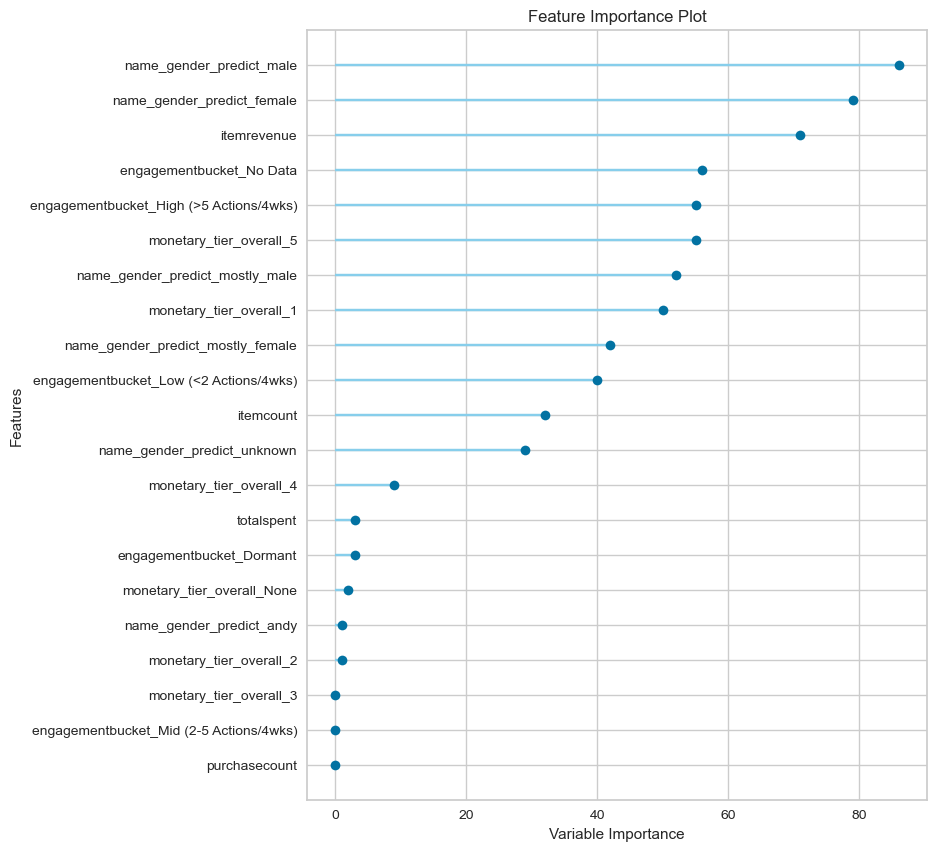

In [ ]:
plot_model(best_model, plot="feature_all")

In [ ]:
predict_model(best_model)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.8730,0,0.5677,0.8643,0.8681,0.7025,0.7039


,itemcount,itemrevenue,purchasecount,totalspent,monetary_tier_overall_1,monetary_tier_overall_2,monetary_tier_overall_3,monetary_tier_overall_4,monetary_tier_overall_5,monetary_tier_overall_None,...,engagementbucket_No Data,name_gender_predict_andy,name_gender_predict_female,name_gender_predict_male,name_gender_predict_mostly_female,name_gender_predict_mostly_male,name_gender_predict_unknown,gender,Label,Score
0,0.0,80.282471,11.681081,0.00,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,male,female,0.9064
1,0.0,80.282471,11.681081,0.00,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,female,female,0.8078
2,0.0,80.282471,11.681081,0.00,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,female,female,0.9246
3,0.0,80.282471,11.681081,0.00,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,male,male,0.9587
4,0.0,80.282471,11.681081,0.00,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,male,male,0.9511
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3105,0.0,80.282471,11.681081,0.00,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,male,male,0.9541
3106,1.0,65.000000,10.000000,85.68,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,male,male,0.9582
3107,0.0,80.282471,11.681081,0.00,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,male,female,0.5596
3108,0.0,80.282471,11.681081,0.00,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,male,male,0.9563


# Inference Tests

The value of unknowns shows that the inherent bias of the model is roughly 20% skew to male. If there is no name (unknown name) it will predict male with 70% confidence.

unknown	male	0.702979

In [ ]:
query = """
select cc.gender, cc.dimcustomermasterid, cc.lkupclientid, cc.namefirst, cc.income, cc.education, cc.occupation, cc.monetary_tier_overall, cc.engagementbucket, cc.loyaltypointbalance, cc.isgamer, cm.itemdescription, cm.itemcount, cm.itemrevenue, ccon.purchasecount, ccon.totalspent
from dw.cohortcustomer cc 
	left join dw.cohortmerch cm on cc.dimcustomermasterid = cm.dimcustomermasterid 
	left join dw.cohortconcession ccon on cc.dimcustomermasterid = ccon.dimcustomermasterid 
where cc.gender is null;
"""

cluster = "prod-app"
database = "stlrtrailblazers"

In [ ]:
conn = redshift_tools.get_redshift_connection(cluster, database)

cur = conn.cursor()
cur.execute(query)

data = cur.fetchall()

cols = [row[0] for row in cur.description]
df = pd.DataFrame(data=data, columns=cols)

conn.close()

Authorized as AROASQ4JELIXYLYV6P4UV:pmorrison@stellaralgo.com


In [ ]:
inference_name = df

In [ ]:
inference_name.shape

(1554332, 16)

### Pre-Processing

We will preprocess the data, so we can have a predicted score of their gender and clean other data.

In [ ]:
gdectect = gender.Detector()

In [ ]:
inference_name["name_gender_predict"] = inference_name["namefirst"].apply(gdectect.get_gender)

In [ ]:
inference_name.name_gender_predict.value_counts()

male             611881
female           467836
unknown          312147
mostly_male       75009
mostly_female     73707
andy              13752
Name: name_gender_predict, dtype: int64

In [ ]:
inference_name["totalspent"] = inference_name["totalspent"].fillna(0)

In [ ]:
inference_name["itemcount"] = inference_name["itemcount"].fillna(0)

In [ ]:
inference_name = inference_name.drop(columns=["gender"], axis=1)

In [ ]:
name_results = predict_model(final_model, inference_name)

In [ ]:
name_results.groupby(["name_gender_predict", "Label"]).agg({"Score":"mean"})

Score
name_gender_predict Label           
andy                male    0.695152
female              female  0.817917
male                male    0.956184
mostly_female       female  0.574937
                    male    0.594399
mostly_male         male    0.909137
unknown             male    0.702979

# Train with Smote

The results of the compare model below, shows that smote does not help improve over non-smote implementation

In [ ]:
setup(
    data=df_temp,
    target='gender',
    train_size=0.85,
    data_split_shuffle=True,
    silent=True,
    verbose=False,
    fix_imbalance=True,
    ignore_features=["dimcustomermasterid", "lkupclientid", "namefirst", "itemdescription"],
    numeric_features=["totalspent"]
)

In [ ]:
smote_model_matrix = compare_models(
    fold=2,
    include= ["lightgbm", "catboost", "rf", "svm", "xgboost"]
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.7206,0.9007,0.5629,0.8548,0.7761,0.4907,0.5202,4.5800
lightgbm,Light Gradient Boosting Machine,0.7204,0.9001,0.5600,0.8545,0.7761,0.4902,0.5196,0.4450
rf,Random Forest Classifier,0.7198,0.8997,0.5625,0.8541,0.7752,0.4894,0.5191,0.2400
svm,SVM - Linear Kernel,0.5483,0.0000,0.5569,0.8826,0.5875,0.3672,0.4513,0.2750


# Train without Name Data

We wanted to determine if name_gender_predict is the most important factor in predicting a persons gender.

The result of this test is that the accuracy is worse than randomly guessing without the name_gender_predict feature.

In [ ]:
setup(
    data=df_temp,
    target='gender',
    train_size=0.85,
    data_split_shuffle=True,
    silent=True,
    verbose=False,
    ignore_features=["dimcustomermasterid", "lkupclientid", "namefirst", "itemdescription", "name_gender_predict"],
    numeric_features=["totalspent"]
)

In [ ]:
smote_model_matrix = compare_models(
    fold=2,
    include= ["lightgbm", "catboost", "rf", "svm", "xgboost", "dummy"]
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dummy,Dummy Classifier,0.6776,0.5000,0.3333,0.4591,0.5474,0.0000,0.0000,0.0650
svm,SVM - Linear Kernel,0.6757,0.0000,0.3343,0.5928,0.5526,0.0064,0.0220,0.1350
catboost,CatBoost Classifier,0.6747,0.5491,0.3361,0.5943,0.5588,0.0111,0.0294,1.5750
lightgbm,Light Gradient Boosting Machine,0.6732,0.5460,0.3353,0.5826,0.5578,0.0078,0.0202,0.3350
rf,Random Forest Classifier,0.6720,0.5463,0.3352,0.5785,0.5586,0.0077,0.0180,0.1750


# Train with only name_gender_predict


In [ ]:
setup(
    data=df_temp,
    target='gender',
    train_size=0.85,
    data_split_shuffle=True,
    silent=True,
    verbose=False,
    ignore_features=['dimcustomermasterid', 'lkupclientid', 'namefirst', 'income',
       'education', 'occupation', 'monetary_tier_overall', 'engagementbucket',
       'loyaltypointbalance', 'isgamer', 'itemdescription', 'itemcount',
       'itemrevenue', 'purchasecount', 'totalspent']
)

In [ ]:
smote_model_matrix = compare_models(
    fold=2,
    include= ["lightgbm", "catboost", "rf", "svm", "xgboost", "dummy", "lr"]
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.8744,0.9073,0.5683,0.8664,0.8698,0.7063,0.7078,0.0800
catboost,CatBoost Classifier,0.8744,0.9073,0.5683,0.8664,0.8698,0.7063,0.7078,1.0700
rf,Random Forest Classifier,0.8744,0.9073,0.5683,0.8664,0.8698,0.7063,0.7078,0.1100
svm,SVM - Linear Kernel,0.8744,0.0000,0.5683,0.8664,0.8698,0.7063,0.7078,0.0200
xgboost,Extreme Gradient Boosting,0.8744,0.9073,0.5683,0.8664,0.8698,0.7063,0.7078,0.3300
lr,Logistic Regression,0.8744,0.9073,0.5683,0.8664,0.8698,0.7063,0.7078,0.0500
dummy,Dummy Classifier,0.6789,0.5000,0.3333,0.4610,0.5491,0.0000,0.0000,0.0150
